In [2]:
#install fastai2
!pip install -Uqq fastbook wandb
import fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.8/258.8 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.0 MB/s eta 0:00:00


In [3]:
#imports
from fastbook import *
from fastai.vision.widgets import *
from fastai.callback.wandb import WandbCallback
from fastai.callback.tracker import SaveModelCallback

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from plotnine import *
import shutil
import wandb

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Drive ส่วนตัว
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# ส่วนการสร้าง Model
path = Path("drive/MyDrive/Dataset/Main งู")
print(path)

drive/MyDrive/Dataset/Main งู


In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(),
    get_y=parent_label,
    item_tfms=Resize(512, method=ResizeMethod.Squish),
    batch_tfms=aug_transforms(size=512, flip_vert=True),
    )
dls = dblock.dataloaders(path, bs=64)

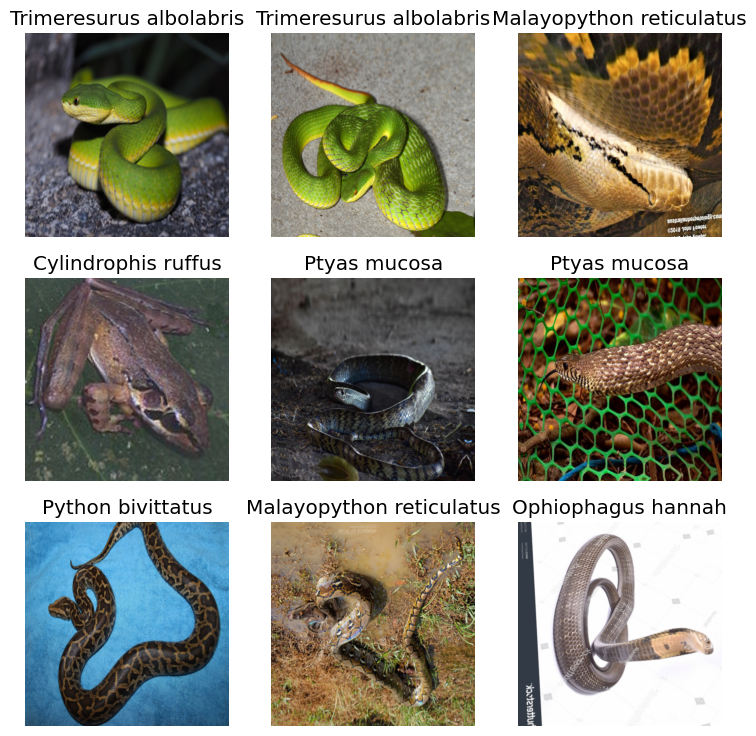

In [ ]:
dls.train.show_batch(max_n=9, nrows=3)

In [ ]:
learn = cnn_learner(dls,
                    resnet34,
                    metrics=[accuracy]).to_fp16()

SuggestedLRs(valley=0.0010000000474974513)

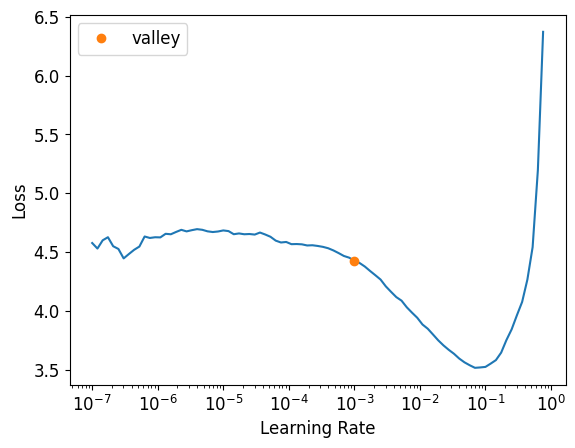

In [ ]:
learn.lr_find()

In [ ]:
wandb.init(project='snake')

In [ ]:
learn.fine_tune(epochs=30,
          base_lr=1e-3,
          freeze_epochs=1,
          lr_mult=100,
          pct_start=0.2,
          div=5.0,
          cbs=[WandbCallback()
             ]
          )

In [ ]:
# Save Model
learn.export()
path = Path()
path.ls(file_exts = ".pkl")

In [9]:
# ส่วนการใช้งาน Model
# ใส่ตำแหน่ง File Model ใน Drive

learn_inf = load_learner("drive/MyDrive/Dataset/export.pkl")

In [10]:
snake = {"Ophiophagus hannah" : "มีพิษ",
    "Naja kaouthia" : "งูเห่าหม้อ, มีพิษ",
    "Bungarus fasciatus" : "งูสามเหลี่ยม, มีพิษ",
    "Bungarus candidus" : "งูทับสมิงคลา, มีพิษ",
    "Daboia siamensis" : "งูแมวเซา, มีพิษ",
    "Calloselasma rhodostoma" : "งูกะปะ, มีพิษ",
    "Trimeresurus albolabris" : "งูเขียวหางไหม้ท้องเหลือง, มีพิษ",
    "Trimeresurus macrops" : "งูเขียวหางไหม้ตาโต, มีพิษ",
    "Xenopeltis unicolor" : "งูแสงอาทิตย์, ไม่มีพิษ",
    "Ptyas korro" : "งูสิงธรรมดา, ไม่มีพิษ",
    "Coelognathus radiatus" : "งูทางมะพร้าวธรรมดา, ไม่มีพิษ",
    "Chrysopelea ornata" : "งูเขียวพระอินทร์, มีพิษ (อ่อน)",
    "Malayopython reticulatus" : "งูเหลือม, ไม่มีพิษ",
    "Python bivittatus" : "งูหลาม, ไม่มีพิษ",
    "Ptyas mucosa" : "งูสิงหางลาย, มีพิษ (อ่อน)",
    "Ahaetulla nasuta" : "งูเขียวปากแหนบ, มีพิษ (อ่อน)",
    "Rhabdophis subminiatus" : "งูลายสาบคอแดง, มีพิษ",
    "Cylindrophis ruffus" : "งูก้นขบ, ไม่มีพิษ"
    }

btn_upload = widgets.FileUpload()
lbl_pred = widgets.Label()
out_pl = widgets.Output()

def on_click_classify(change):
    if len(btn_upload.data) == 0 :
      return

    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()

    with out_pl: display(img.to_thumb(128,128))
    pred, pred_idx, probs = learn_inf.predict(img)

    possi = ""
    if probs[pred_idx] < 0.4 :
      possi = "(ความเป็นไปได้ต่ำ)"
    lbl_pred.value = f'{possi} ชื่อ : {pred} {snake[pred]} ; ความเป็นไปได้ : {probs[pred_idx]:.04f}'

btn_run = widgets.Button(description='Click')
btn_run.on_click(on_click_classify)
btn_upload = widgets.FileUpload()

In [11]:
VBox([widgets.Label('Snake'),
      btn_upload, btn_run, out_pl, lbl_pred])